# Adding non-stationarity

In this notebook we add non-stationarity into the nursery dataset.

Here we follow the setting in [1] and just invert the class labels at a specified time point, simulating concept shift.

[1] Context Attentive Bandits: Contextual Bandit with Restricted Context https://arxiv.org/pdf/1705.03821.pdf


In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

# For debug and testing drop some more columns
# all_contexts = all_contexts.drop(['form'], axis=1).to_numpy()
all_contexts = all_contexts.drop(['finance', 'form'], axis=1).to_numpy()

In [14]:
all_contexts.shape

(12960, 3)

In [15]:
all_contexts

array([[1, 1, 2],
       [1, 1, 3],
       [1, 1, 1],
       ...,
       [4, 3, 2],
       [4, 3, 3],
       [4, 3, 1]], dtype=int8)

In [16]:
y = df_num['final evaluation']

In [17]:
np.sum(np.where(y == 3, 1, 0))

328

In [18]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [19]:
all_rewards

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [20]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320,    2,  328, 4266, 4044])

### Fixed costs

In [21]:
costs_vector = np.zeros(all_contexts.shape)
for i in range(all_contexts.shape[0]):
    costs_vector[i, :] = np.array([0.01]*all_contexts.shape[1])

costs_vector.shape

(12960, 3)

In [22]:
costs_vector

array([[0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01]])

### Find which features are useful

It might be useful to move this to another notebook later for better organization.

In [23]:
from sklearn.linear_model import LinearRegression, LogisticRegression


coefs = np.zeros((5, all_contexts.shape[1]))
for n_arm in range(5):
    print(n_arm)
    model = LogisticRegression()
    model.fit(all_contexts, all_rewards[:, n_arm])
    print(model.coef_)
    coefs[n_arm, :] = model.coef_


0
[[ 6.61707720e-06  5.73863246e-06 -1.18003252e+01]]
1
[[-1.00676222e+00 -9.19989322e-01 -1.34647361e-05]]
2
[[-5.19869325e-01 -1.02126714e+00  3.56913628e-07]]
3
[[-0.12709846 -0.22510646  1.08402768]]
4
[[0.23413415 0.41835275 1.7042506 ]]


In [24]:
np.mean(coefs, axis= 0)

array([-0.28391785, -0.34960089, -1.80241201])

## Algorithm evaluation

In [25]:
NUM_OF_TRIALS = all_contexts.shape[0]

In [26]:
NUM_REPETITIONS = 1

In [27]:
BETA = 1

In [28]:
np.random.seed(42)

In [29]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 2652.0
	Total reward: 2652.0
	Total cost: 0
Execution time: 0.1s
Average gain: 2652.0


In [30]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=all_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4282.0
	Total reward: 4282.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4282.0


In [31]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=all_rewards.shape[1],
            alpha=0.45,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb
    
gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Beta = 1
Total gain: 6645.0
	Total reward: 6645.0
	Total cost: 0
Execution time: 0.1s
Average gain: 6645.0


In [32]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=all_contexts.shape[1],
        n_arms=all_rewards.shape[1],
        alpha=0.45,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.45)
Beta = 1
Total gain: 7444.200000001182
	Total reward: 7833.0
	Total cost: 388.79999999988814
Execution time: 0.6s
Average gain: 7444.200000001182


In [33]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=all_contexts.shape[1],
        n_arms=all_rewards.shape[1],
        alpha=0.1,
        omega=500,
        delta=0.15,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Beta = 1
Total gain: 6838.2000000009375
	Total reward: 7227.0
	Total cost: 388.79999999988814
Execution time: 2.3s
Average gain: 6838.2000000009375


In [34]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=all_contexts, 
        number_of_actions=all_rewards.shape[1],
        max_no_red_context=all_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.08,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            all_contexts[:NUM_OF_TRIALS],
            all_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0007982254028320312 seconds
Trial 0, time 2022-05-02 18:36:10.032802
Trial 500, time 2022-05-02 18:36:11.918807
Trial 1000, time 2022-05-02 18:36:12.024036
Trial 1500, time 2022-05-02 18:36:12.151326
Trial 2000, time 2022-05-02 18:36:12.230440
Trial 2500, time 2022-05-02 18:36:12.358287
Trial 3000, time 2022-05-02 18:36:12.614274
Trial 3500, time 2022-05-02 18:36:12.691569
Trial 4000, time 2022-05-02 18:36:12.742869
Trial 4500, time 2022-05-02 18:36:13.151694
Trial 5000, time 2022-05-02 18:36:13.763116
Trial 5500, time 2022-05-02 18:36:14.197268
Trial 6000, time 2022-05-02 18:36:14.299767
Trial 6500, time 2022-05-02 18:36:14.402471
Trial 7000, time 2022-05-02 18:36:14.453159
Trial 7500, time 2022-05-02 18:36:14.504427
Trial 8000, time 2022-05-02 18:36:14.554999
Trial 8500, time 2022-05-02 18:36:14.609779
Trial 9000, time 2022-05-02 18:36:14.666240
Trial 9500, time 2022-05-02 18:36:14.718968
Trial 10000, time 2022-05-02 18:36:14.800801
Trial 10500, time 2022-05-02 18:36:14.935014

In [35]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=all_contexts, 
        number_of_actions=all_rewards.shape[1],
        max_no_red_context=all_contexts.shape[1],
        beta=BETA,
        delta=0.1,
        window_length=1000,
        feature_flag=True,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            all_contexts[:NUM_OF_TRIALS],
            all_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0016548633575439453 seconds
Round 0, time 2022-05-02 18:36:15.338536
Round 500, time 2022-05-02 18:36:31.261773
Round 1000, time 2022-05-02 18:36:49.984723
Round 1500, time 2022-05-02 18:37:08.698361
Round 2000, time 2022-05-02 18:37:27.376730
Round 2500, time 2022-05-02 18:37:46.072109
Round 3000, time 2022-05-02 18:38:03.916246
Round 3500, time 2022-05-02 18:38:22.218130
Round 4000, time 2022-05-02 18:38:39.942239
Round 4500, time 2022-05-02 18:38:57.601817
Round 5000, time 2022-05-02 18:39:15.610303
Round 5500, time 2022-05-02 18:39:33.148604
Round 6000, time 2022-05-02 18:39:51.215954
Round 6500, time 2022-05-02 18:40:09.823114
Round 7000, time 2022-05-02 18:40:27.801083
Round 7500, time 2022-05-02 18:40:45.516611
Round 8000, time 2022-05-02 18:41:03.273800
Round 8500, time 2022-05-02 18:41:20.764553
Round 9000, time 2022-05-02 18:41:38.922243
Round 9500, time 2022-05-02 18:41:57.308701
Round 10000, time 2022-05-02 18:42:15.672245
Round 10500, time 2022-05-02 18:42:33.174085

In [36]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [37]:
(gain_egreedy / gain_random).shape

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_84298/834796977.py:1: RuntimeWarning: divide by zero encountered in true_divide
  (gain_egreedy / gain_random).shape
/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_84298/834796977.py:1: RuntimeWarning: invalid value encountered in true_divide
  (gain_egreedy / gain_random).shape


(12960,)

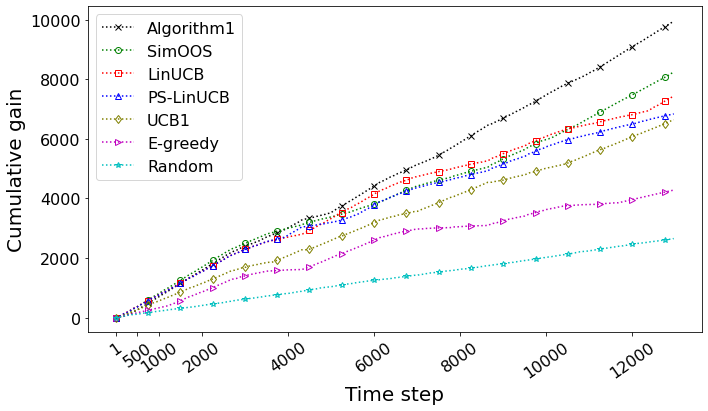

In [38]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


# Adding non-stationarity


### Non-stationarity in rewards

In [39]:
all_rewards.shape[0]

12960

In [40]:
# inverted_regions = [
#     slice(2000, 5000),
#     slice(10000, 11000),
# ]

In [41]:
inverted_regions = [
    slice(500, 1000),
    slice(1000, 2000),
    slice(200, 5000),
    slice(5000, 8000),
    slice(9000, 11000),
    slice(11000, 12960),
]

In [42]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, 11000),
    slice(11000, 12960),
]

In [43]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([3.33333333e-01, 1.54320988e-04, 2.53086420e-02, 3.29166667e-01,
       3.12037037e-01])

In [44]:
arm_from_to = [
    {
        0: 3,
        3: 0,
        1: 2,
        2: 1,
    },
    {
        0: 1,
        1: 0,
    },
    {
        0: 2,
        2: 0,
        1: 3,
        3: 1
    },
    {
        0: 3,
        3: 0,
        1: 2,
        2: 1,
    },
    {
        0: 3,
        3: 0,
        1: 2,
        2: 1,
    },
    {
        0: 2,
        2: 0,
        1: 3,
        3: 1
    },
]

In [45]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [46]:
new_contexts.shape, new_rewards.shape

((12960, 3), (12960, 5))

### Non-stationarity in costs

In [47]:
cost_change_points = [3000, 5000, 7000, 9000, 11000]
interval_count = len(cost_change_points) + 1

In [48]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.1, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [49]:
interval_means

[array([0.04412307, 0.0150682 , 0.09327941]),
 array([0.08697457, 0.09398633, 0.01426907]),
 array([0.07192827, 0.06588557, 0.09050858]),
 array([0.04719345, 0.02993677, 0.02340209]),
 array([0.04752155, 0.08165724, 0.03515745]),
 array([0.04427479, 0.07925949, 0.06614882])]

In [50]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [51]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

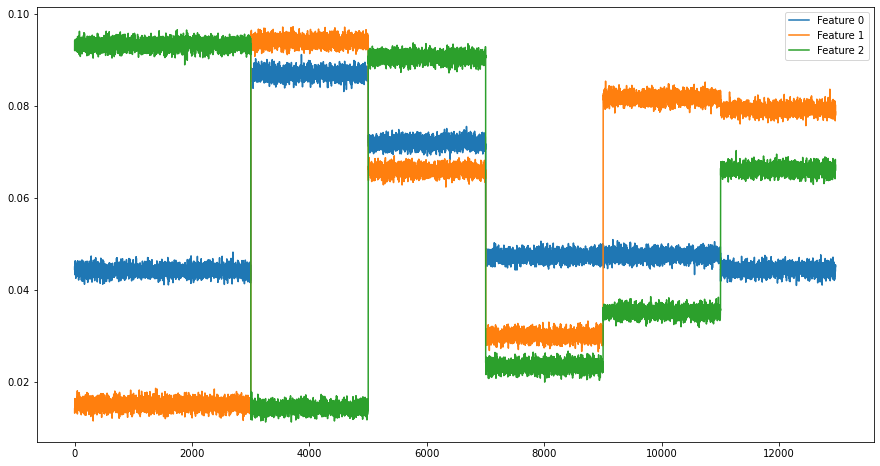

In [52]:
plot_costs(get_costs(), new_contexts.shape[0])

In [53]:
costs_obj = get_costs()

In [54]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [55]:
costs_vector.shape

(12960, 3)

## Plot expected reward minus sum of costs

Min expected gain for arm 1: -0.20161285607902438
Min expected gain for arm 2: -0.23538689511768482
Min expected gain for arm 3: -0.2333889060303621
Min expected gain for arm 4: -0.2333889060303621
Min expected gain for arm 5: -0.19978401006541902


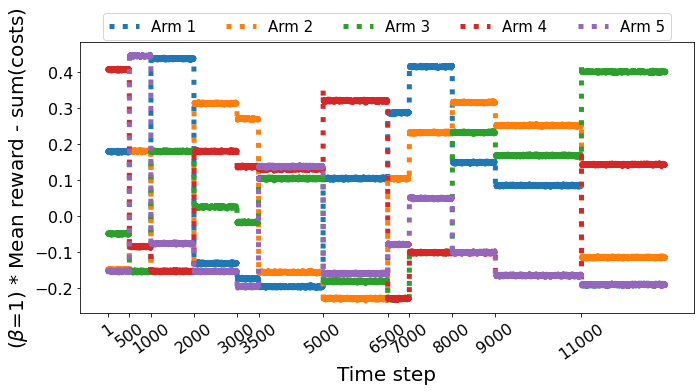

In [56]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 500, 1000, 2000, 3000, 3500, 5000, 6500, 7000, 8000, 9000, 11000]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Testing on non-stationary data

In [57]:
np.random.seed(42)

In [58]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 2566.0
	Total reward: 2566.0
	Total cost: 0
Execution time: 0.1s
Average gain: 2566.0


In [59]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 2935.0
	Total reward: 2935.0
	Total cost: 0
Execution time: 0.1s
Average gain: 2935.0


In [60]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.45,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Beta = 1
Total gain: 5954.0
	Total reward: 5954.0
	Total cost: 0
Execution time: 0.2s
Average gain: 5954.0


In [61]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 2314.7684271052103
	Total reward: 4521.0
	Total cost: 2206.2315728947906
Execution time: 0.5s
Average gain: 2314.7684271052103


In [62]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.03,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5736.7684271051685
	Total reward: 7943.0
	Total cost: 2206.2315728947906
Execution time: 0.6s
Average gain: 5736.7684271051685


In [63]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.08,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0009589195251464844 seconds
Trial 0, time 2022-05-02 18:44:03.014587
Trial 500, time 2022-05-02 18:44:04.767034
Trial 1000, time 2022-05-02 18:44:05.181376
Trial 1500, time 2022-05-02 18:44:05.545256
Trial 2000, time 2022-05-02 18:44:06.748661
Trial 2500, time 2022-05-02 18:44:06.815347
Trial 3000, time 2022-05-02 18:44:06.880378
Trial 3500, time 2022-05-02 18:44:06.921703
Trial 4000, time 2022-05-02 18:44:07.555166
Trial 4500, time 2022-05-02 18:44:07.642343
Trial 5000, time 2022-05-02 18:44:07.934913
Trial 5500, time 2022-05-02 18:44:08.227683
Trial 6000, time 2022-05-02 18:44:08.453440
Trial 6500, time 2022-05-02 18:44:08.752538
Trial 7000, time 2022-05-02 18:44:08.865769
Trial 7500, time 2022-05-02 18:44:08.907031
Trial 8000, time 2022-05-02 18:44:08.948326
Trial 8500, time 2022-05-02 18:44:08.990011
Trial 9000, time 2022-05-02 18:44:09.426237
Trial 9500, time 2022-05-02 18:44:09.866678
Trial 10000, time 2022-05-02 18:44:10.040718
Trial 10500, time 2022-05-02 18:44:10.159846

In [64]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=1.0,
        window_length=250,
        feature_flag=True,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.006768703460693359 seconds
Round 0, time 2022-05-02 18:44:10.872070
Round 500, time 2022-05-02 18:44:24.838732
Round 1000, time 2022-05-02 18:44:39.445127
Round 1500, time 2022-05-02 18:44:53.846965
Round 2000, time 2022-05-02 18:45:08.246804
Round 2500, time 2022-05-02 18:45:22.929866
Round 3000, time 2022-05-02 18:45:37.148618
Round 3500, time 2022-05-02 18:45:51.417870
Round 4000, time 2022-05-02 18:46:05.658352
Round 4500, time 2022-05-02 18:46:19.881786
Round 5000, time 2022-05-02 18:46:34.029580
Round 5500, time 2022-05-02 18:46:48.268540
Round 6000, time 2022-05-02 18:47:02.682348
Round 6500, time 2022-05-02 18:47:16.996289
Round 7000, time 2022-05-02 18:47:31.245535
Round 7500, time 2022-05-02 18:47:45.411012
Round 8000, time 2022-05-02 18:47:59.788152
Round 8500, time 2022-05-02 18:48:14.082192
Round 9000, time 2022-05-02 18:48:28.941801
Round 9500, time 2022-05-02 18:48:43.124100
Round 10000, time 2022-05-02 18:48:57.454028
Round 10500, time 2022-05-02 18:49:11.663874


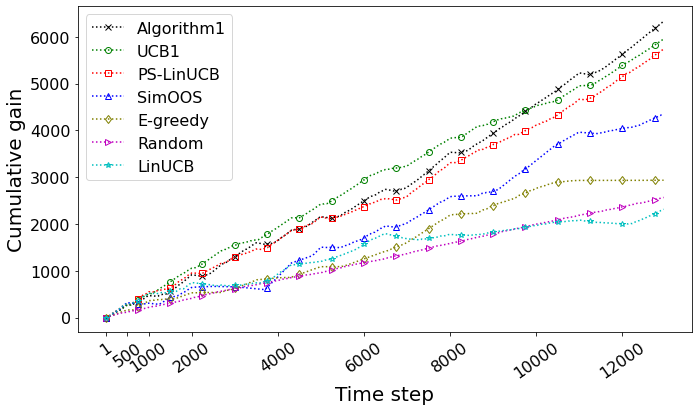

In [65]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


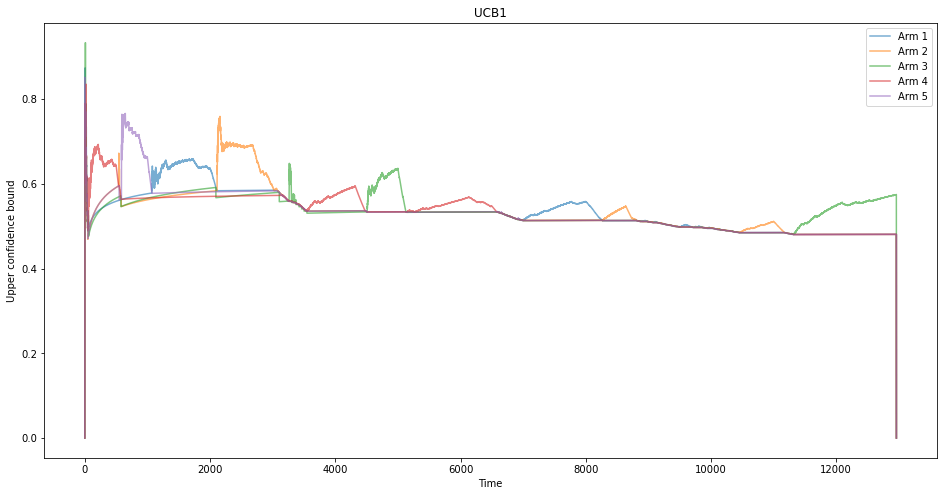

In [66]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ucb_alg.ucbs[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('UCB1');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

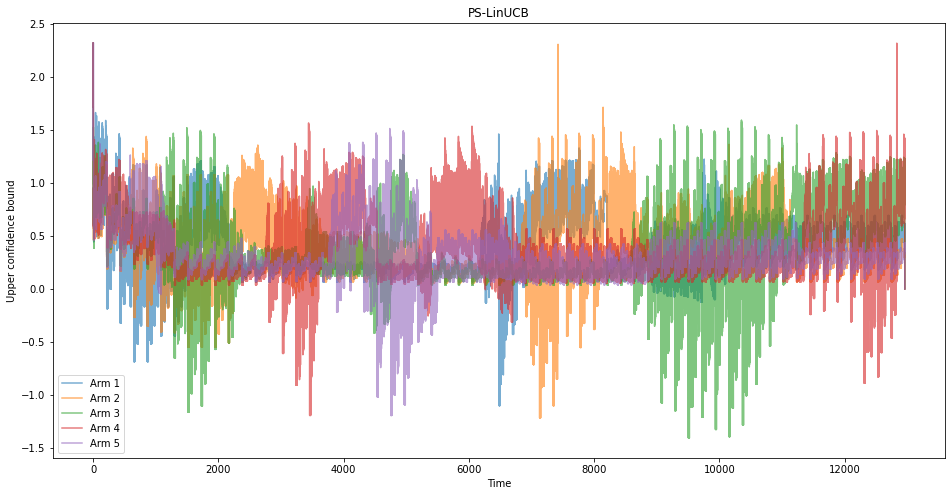

In [67]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ps_linucb.ucbs[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('PS-LinUCB');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

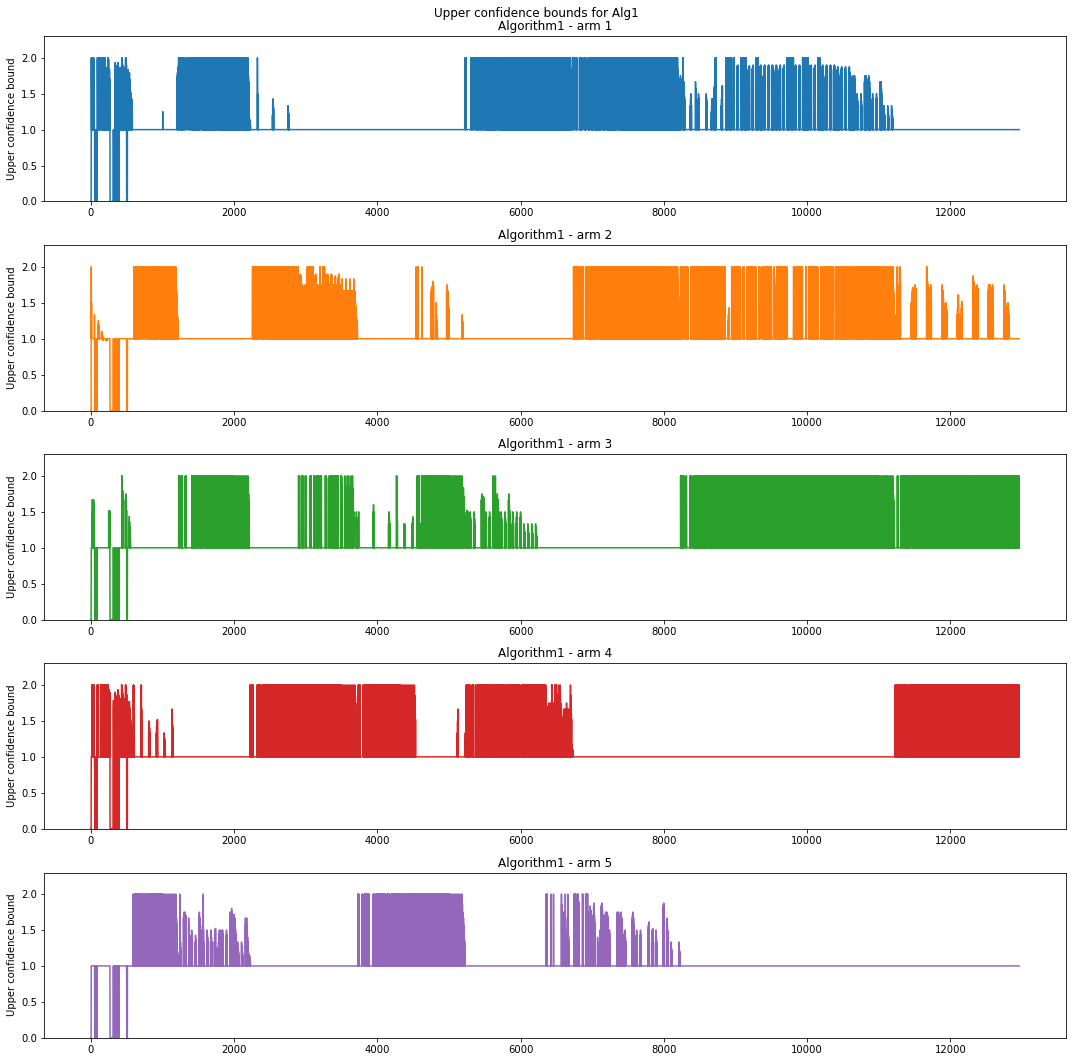

In [68]:
fig, ax = plt.subplots(5,1, figsize=(15, 15))
fig.suptitle('Upper confidence bounds for Alg1')
for i in range(5):
    ax[i].plot(p_alg1.ucbs[:NUM_OF_TRIALS, i], color=plt.cm.tab10(i));
    ax[i].set_title(f"Algorithm1 - arm {i+1}");
    ax[i].set_ylabel('Upper confidence bound');
    ax[i].set_ylim([0.0, 2.3])

plt.tight_layout();

In [69]:
list(p_alg1.selected_context_SimOOS)

[array([0., 0., 0.]),
 array([0., 0., 1.]),
 array([0., 1., 0.]),
 array([0., 1., 1.]),
 array([1., 0., 0.]),
 array([1., 0., 1.]),
 array([1., 1., 0.]),
 array([1., 1., 1.]),
 array([0., 1., 1.]),
 array([0., 1., 1.]),
 array([1., 0., 1.]),
 array([0., 1., 1.]),
 array([0., 1., 1.]),
 array([0., 1., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([0., 1., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([1., 0., 1.]),
 array([0., 1., 1.]),
 array([1., 0., 1.]),
 array([1.

In [70]:
list(p_alg1.costs)

[array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([-0.95602587, -0.98449786, -0.90713004]),
 array([-0.95602587, -0.98465507, -0.90694168]),
 array([-0.95602587, -0.98463241, -0.90683303]),
 array([-0.95556775, -0.98463241, -0.90689014]),
 array([-0.95556775, -0.98458718, -0.90672783]),
 array([-0.95556775, -0.98473528, -0.85226668]),
 array([-0.95556775, -0.93012258, -0.80368528]),
 array([-0.9557302 , -0.93012258, -0.76193076]),
 array([-0.95571992, -0.93012258, -0.72550253]),
 array([-0.95565468, -0.93012258, -0.69335859]),
 array([-0.90105728, -0.93012258, -0.66476755]),
 array([-0.85261381, -0.93012258, -0.63908181]),
 array([-0.8107547 , -0.93012258, -0.61576515]),
 array([-0.77451304, -0.93012258, -0.59458648]),
 array([-0.74235747, -0.93012258, -0.57516333]),
 array([-0.71377976, -0.93012258, -0.55729215]),
 array([-0.68809803, -0.93012258, -0.540